<h1><center>Netflix TV Shows And Movie Analysis</center></h1>

![Netflixloading.jpg](attachment:Netflixloading.jpg)


#####  Image credit:https://streamdiag.com/netflix-is-stuck-on-loading-screen-fix/

Netflix was founded in 1997 by Reed Hastings and Marc Randolph
The company's primary business is a subscription-based streaming service offering online streaming.
Netflix is headquartered in Los Gatos, California.
In this Analysis we will answer the following questions through visualistions

### Questions
1. What contents Neflix has most
2. Top contents by ratings
3. Countries with most content
4. Busiest month for content release
5. Total contents by Season
6. Top ten TV shows
7. Movie released by ratings since 2016
8. Tv Shows India has by ratings
9. Tv Shows USA has by ratings
10. Top 10 Movie genre

 ### Import Necessary Libraries 

In [1]:
!pip install pyspark

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
%matplotlib inline
import requests
import re

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cur_path='/content/gdrive/MyDrive/class/big_data/final-project/'

### Load the Dataset

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("netflix-eda").getOrCreate()

In [6]:
country_code = spark.read.csv(cur_path+'data/country_code.csv',inferSchema =True, header=True)
country_code = country_code.select('name','alpha-3')
df = spark.read.csv(cur_path+'data/netflix_titles.txt',inferSchema =True, header=True,sep='\t')
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- show_id: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)



# Exploratory Data Analysis

### Check for Missing Values

In [7]:
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import lit
from pyspark.sql.functions import col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|_c0|show_id|type|title|director|cast|country|date_added|release_year|rating|duration|listed_in|description|
+---+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|  0|      0|   0|    0|    1969| 570|    476|        11|           0|    10|       0|        0|          0|
+---+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+



### Handling Missing Values

* Replace missing values with mode for ratings, country,
release year,type and listed_in  column.

* Replace nan values in data_added with January 1 and mode for release year.

* Replace nan value in director and cast columns with "unknown", replace nan value in description column with "no description".

In [8]:
rating_mode=df.groupby("rating").count().orderBy("count", ascending=False).first()[0]
country_mode=df.groupby("country").count().orderBy("count", ascending=False).first()[0]
release_year_mode=df.groupby("release_year").count().orderBy("count", ascending=False).first()[0]
duration_mode=df.groupby("duration").count().orderBy("count", ascending=False).first()[0]
type_mode=df.groupby("type").count().orderBy("count", ascending=False).first()[0]
list_mode=df.groupby("listed_in").count().orderBy("count", ascending=False).first()[0]

In [9]:
df1=df.na.fill({"rating": rating_mode, 
            "country": country_mode,
            "date_added":'1-Jan-{}'.format(release_year_mode),
            "release_year":release_year_mode,
            "duration":duration_mode,
            "director":'unknown',
            "cast":'unknown',
            'description':'no description',
            "type":type_mode,
            "listed_in":list_mode
            }) 


 verify dataset has no missing values

In [10]:
df1.select([count(when(col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

+---+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|_c0|show_id|type|title|director|cast|country|date_added|release_year|rating|duration|listed_in|description|
+---+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|  0|      0|   0|    0|       0|   0|      0|         0|           0|     0|       0|        0|          0|
+---+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+



### Feature engineering

 Convert duration to numeric

In [11]:
from pyspark.sql.types import IntegerType,StringType
from pyspark.sql.functions import udf
def duration_to_numeric(input):
  return int(input.split()[0])
udf_duration_to_numeric = udf(duration_to_numeric, IntegerType()) # if the function returns an int
df1 = df1.withColumn("duration", udf_duration_to_numeric("duration")) #"_3" being the column name of the column you want to consider

In [12]:
def get_month(date):
 return date.split('-')[1]

udf_get_month = udf(get_month, StringType())
df1=df1.withColumn("release_month",udf_get_month('date_added'))

convert data to pandas

In [13]:
df1_pd=df1.toPandas()

load country code data, manually edit the data for our own "dirty" dataset

In [14]:
country_code_df=country_code.toPandas()
country_code_dict=dict(zip(country_code_df.name.values,country_code_df['alpha-3'].values))
country_code_dict['United States'] = 'USA'
country_code_dict['South Korea'] = 'PRK'
country_code_dict['North Korea'] = 'KOR'
country_code_dict['United Kingdom']='GBR'
country_code_dict['Czech Republic']='CZE'
country_code_dict['East Germany']='DEU'
country_code_dict['Iran']='IRN'
country_code_dict['Russia']='RUS'
country_code_dict['Soviet Union']='RUS'
country_code_dict['Syria']='SYR'
country_code_dict['Taiwan']='TWN'
country_code_dict['Venezuela']='VEN'
country_code_dict['Vietnam']='VNM'
country_code_dict['West Germany']='DEU'
country_code_dict['Vatican City']='ITA'

In [15]:
def get_country_code(input):
  country_list=input.split(', ')
  code_list=[]
  for country in country_list:
    if country[-1]!=',':
      code_list.append(country_code_dict[country] )
    else:
      code_list.append(country_code_dict[country[:-1]] )

  # code_list=[country_code_dict[country] for country in country_list if country[-1]!=',' else country_code_dict[country[:-1]]]
  return ','.join(code_list)


for each country, get its iso-3 code.

In [16]:
code_list=[]
for country in df1_pd.country:
  code_list.append(get_country_code(country))
df1_pd['code']=code_list

In [17]:
df1_pd.head()

,_c0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,release_month,code
0,0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",9-Sep-19,2019,TV-PG,90,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,Sep,"USA,IND,PRK,CHN"
1,1,80117401,Movie,Jandino: Whatever it Takes,unknown,Jandino Asporaat,United Kingdom,9-Sep-16,2016,TV-MA,94,Stand-Up Comedy,"""Jandino Asporaat riffs on the challenges of r...",Sep,GBR
2,2,70234439,TV Show,Transformers Prime,unknown,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,8-Sep-18,2013,TV-Y7-FV,1,Kids' TV,"With the help of three human allies, the Autob...",Sep,USA
3,3,80058654,TV Show,Transformers: Robots in Disguise,unknown,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,8-Sep-18,2016,TV-Y7,1,Kids' TV,When a prison ship crash unleashes hundreds of...,Sep,USA
4,4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,8-Sep-17,2017,TV-14,99,Comedies,When nerdy high schooler Dani finally attracts...,Sep,USA


# Data visualization

##### Movies vs TV Show

Text(0.5, 1.0, 'Movie Vs TV Show')

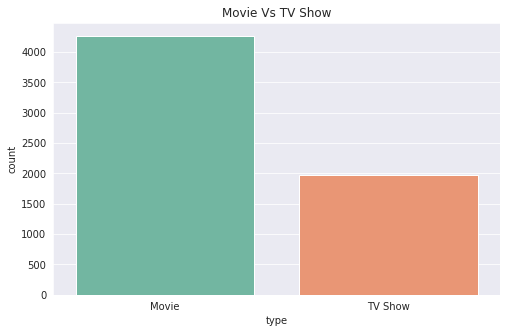

In [18]:
plt.figure(figsize= (8,5))
sns.set_style(style = 'darkgrid')

ax = sns.countplot(x = 'type',data  = df1_pd, palette = 'Set2')
plt.title('Movie Vs TV Show')

##### Number of Contents by Ratings

Text(0, 0.5, 'Total Count')

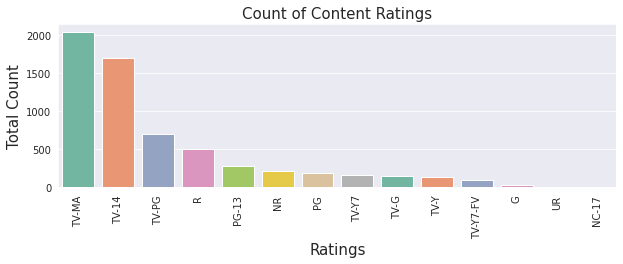

In [19]:
sns.set_style(style = 'darkgrid')
plt.figure(figsize = (10,3))
ax = sns.countplot(x ='rating', data = df1_pd,palette = 'Set2',order = df1_pd['rating'].value_counts().index)
plt.title('Count of Content Ratings',fontsize = 15)
plt.xticks(rotation =90)
plt.xlabel('Ratings',fontsize = 15)
plt.ylabel('Total Count',fontsize = 15)

##### Total number of Tv Shows and Movies by Ratings

Text(0, 0.5, 'Total Count')

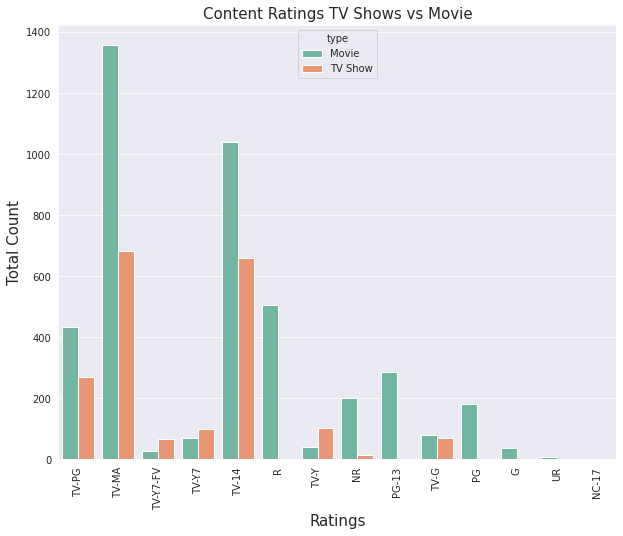

In [20]:
sns.set_style(style = 'darkgrid')
plt.figure(figsize = (10,8))
ax = sns.countplot(data = df1_pd, x= 'rating',hue = 'type', palette='Set2' )
plt.xticks(rotation = 90)
plt.title('Content Ratings TV Shows vs Movie', fontsize = 15)
plt.xlabel('Ratings',fontsize = 15)
plt.ylabel('Total Count',fontsize = 15)

##### Contries with most contents

Text(0, 0.5, 'Number of Movies and TV Shows')

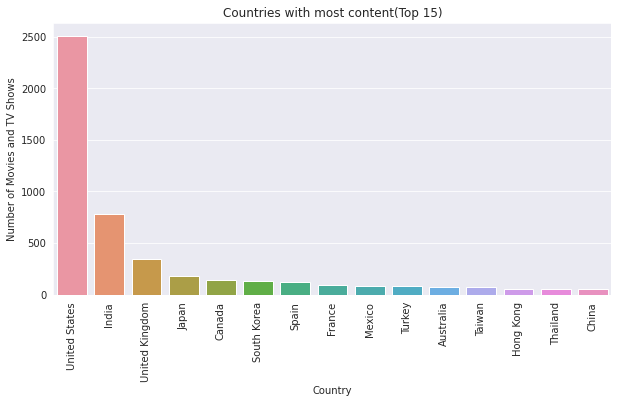

In [21]:
plt.figure(figsize = (10,5))
ax = sns.countplot(x = 'country',data= df1_pd, order = df1_pd['country'].value_counts().index[0:15])
plt.xlabel('Country')
plt.xticks(rotation = 90)
plt.title('Countries with most content(Top 15)')
plt.ylabel('Number of Movies and TV Shows')

##### Busiest Month for Content Release

Text(0.5, 0, 'No. of Releases')

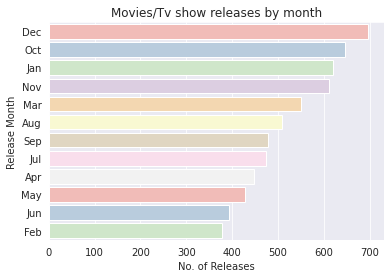

In [22]:

sns.countplot(y = 'release_month',data = df1_pd,palette ='Pastel1', order = df1_pd['release_month'].value_counts().index)
plt.title('Movies/Tv show releases by month')
plt.ylabel('Release Month')
plt.xlabel('No. of Releases')

##### Count of TV Shows by number of seasons

Text(0.5, 1.0, 'Total Tv Show Season wise')

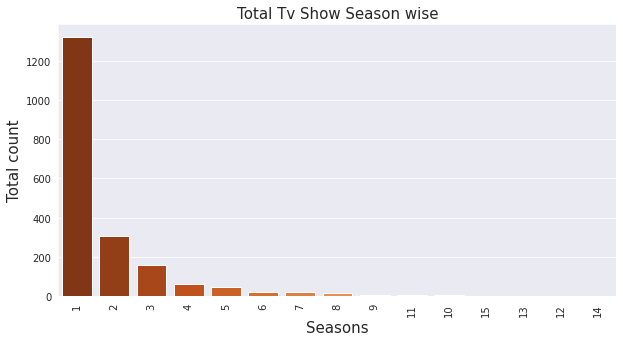

In [23]:
plt.figure(figsize= (10,5))
tv_show = df1_pd[df1_pd['type']== 'TV Show']

sns.countplot(x = 'duration',data = tv_show,palette = 'Oranges_r', order = tv_show['duration'].value_counts().index)
plt.xticks(rotation = 90)
plt.xlabel("Seasons",fontsize = 15)
plt.ylabel("Total count",fontsize = 15)
plt.title("Total Tv Show Season wise",fontsize = 15)

##### Movie Duration

Text(0, 0.5, 'Total Movie Count')

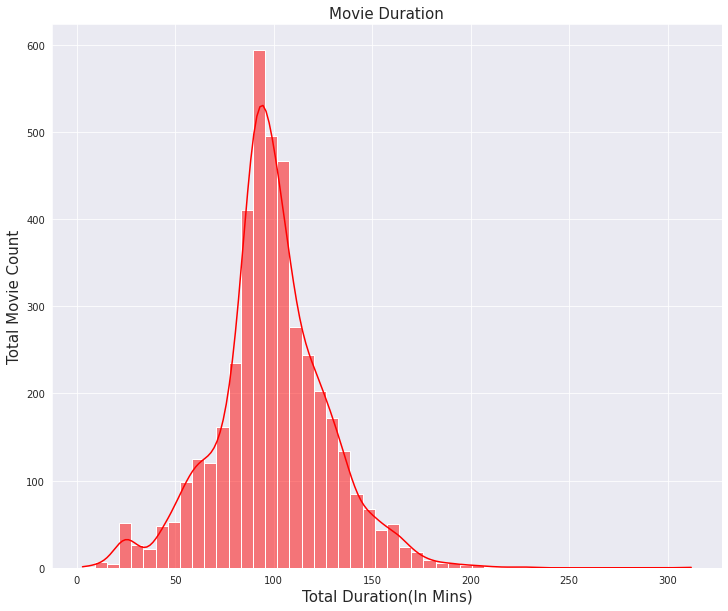

In [24]:
movie_duration = df1_pd.loc[df1_pd['type']=='Movie']

plt.figure(figsize=(12,10))

ax = sns.histplot(data = movie_duration,x = 'duration',bins = 50,kde = True,color = 'red')
plt.title('Movie Duration',fontsize = 15)
plt.xlabel('Total Duration(In Mins)',fontsize = 15)
plt.ylabel('Total Movie Count',fontsize = 15)

##### TOP 10 TV Show

Text(0, 0.5, 'TV Shows')

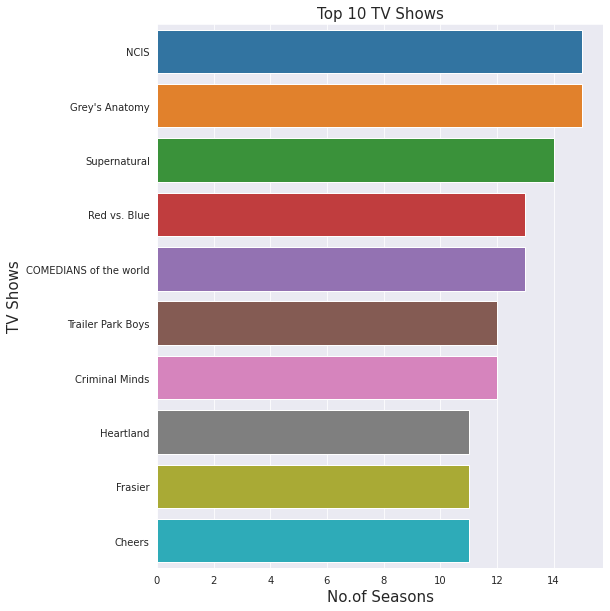

In [25]:
tv_shows = df1_pd.loc[df1_pd['type']=='TV Show']

top10_shows = tv_shows.sort_values(by=['duration'])[-1:-11:-1]
top10_shows[['title','duration']]
plt.figure(figsize=(8,10))
sns.barplot(y = top10_shows['title'], x = top10_shows['duration'])
plt.title('Top 10 TV Shows',fontsize = 15)
plt.xlabel('No.of Seasons',fontsize = 15)
plt.ylabel('TV Shows',fontsize = 15)

##### Tv Shows USA has by rating (trend in last 10 years)

Text(0.5, 1.0, 'TV shows released by United States by ratings')

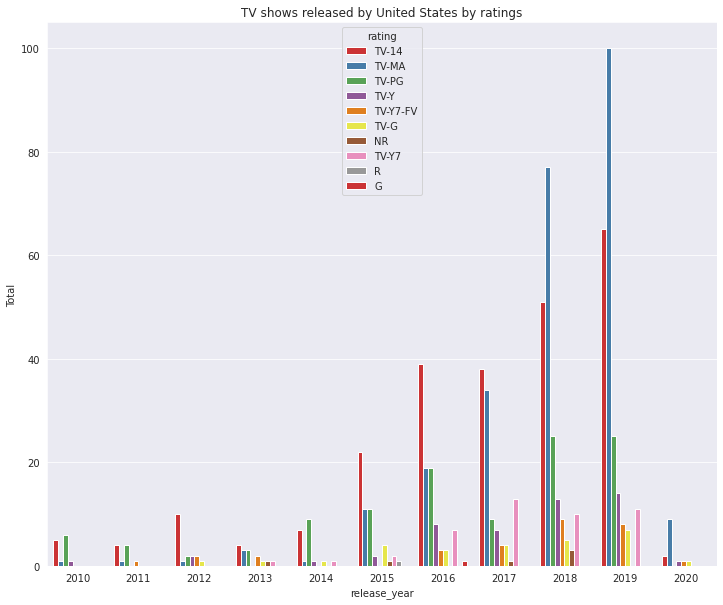

In [26]:
tv_show_USA= df1_pd[(df1_pd['type'] == 'TV Show') & (df1_pd['country'] == 'United States') ]

tv_show_USA = tv_show_USA[tv_show_USA['release_year']>=2010]

df = tv_show_USA.groupby(['release_year','rating']).size().reset_index(name = 'Total')

plt.figure(figsize = (12,10))
sns.set_style('darkgrid')
sns.barplot(data = df,x = 'release_year', y = 'Total',hue = 'rating',palette = 'Set1')
plt.title('TV shows released by United States by ratings')

### Trends of content released Year over Year

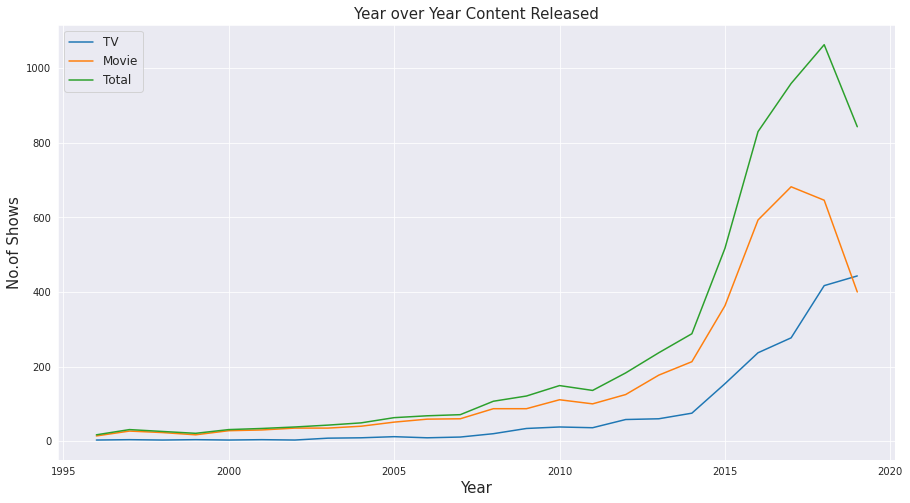

In [27]:
df_ = df1_pd[df1_pd['type'] == 'TV Show'].groupby('release_year').count()[-25:-1]
df1_ = df1_pd[df1_pd['type'] == 'Movie'].groupby('release_year').count()[-25:-1]
df2_ = df1_pd.groupby('release_year').count()[-25:-1]


plt.figure(figsize = (15,8))
sns.set_style('darkgrid')
sns.lineplot(data = df_['show_id'],palette = 'Set1')
sns.lineplot(data = df1_['show_id'],palette = 'Set1')
sns.lineplot(data = df2_['show_id'],palette = 'Set1')
plt.title('Year over Year Content Released',fontsize = 15)
plt.xlabel('Year',fontsize = 15)
plt.ylabel('No.of Shows',fontsize = 15)
plt.legend(['TV', 'Movie','Total'], fontsize='large')

###  Word Cloud


##### Count of most used word in 'Description'

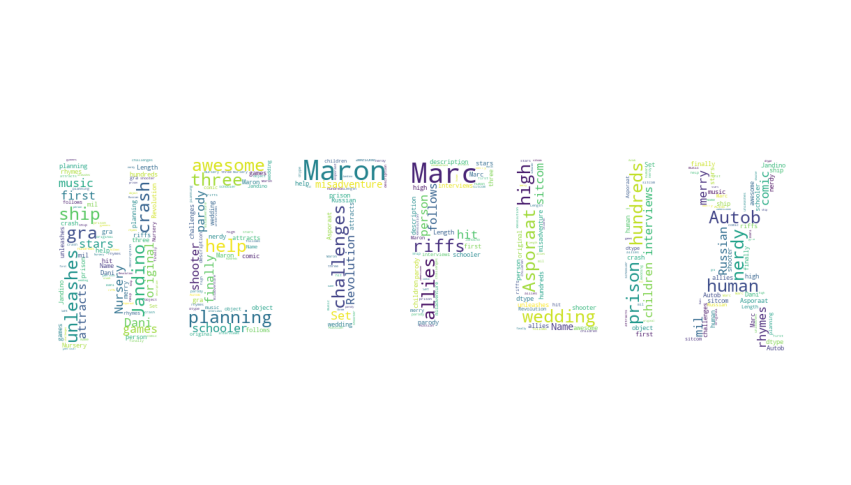

In [28]:
words = (str(df1_pd['description']))
mask = np.array(Image.open(requests.get('https://i.stack.imgur.com/B0AAW.png',stream=True).raw))


def create_wordcloud(words, mask):
    wc = WordCloud(width =500, height =800, background_color='white', 
                   stopwords=STOPWORDS, mask=mask,max_font_size =40,
                  repeat=True,max_words = 300).generate(words)

    plt.figure(figsize=(15,15))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
    

create_wordcloud(words, mask)


create map

In [29]:
df1_pd.head()

,_c0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,release_month,code
0,0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",9-Sep-19,2019,TV-PG,90,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,Sep,"USA,IND,PRK,CHN"
1,1,80117401,Movie,Jandino: Whatever it Takes,unknown,Jandino Asporaat,United Kingdom,9-Sep-16,2016,TV-MA,94,Stand-Up Comedy,"""Jandino Asporaat riffs on the challenges of r...",Sep,GBR
2,2,70234439,TV Show,Transformers Prime,unknown,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,8-Sep-18,2013,TV-Y7-FV,1,Kids' TV,"With the help of three human allies, the Autob...",Sep,USA
3,3,80058654,TV Show,Transformers: Robots in Disguise,unknown,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,8-Sep-18,2016,TV-Y7,1,Kids' TV,When a prison ship crash unleashes hundreds of...,Sep,USA
4,4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,8-Sep-17,2017,TV-14,99,Comedies,When nerdy high schooler Dani finally attracts...,Sep,USA


### Findings
1. Netflix has more movies than Tv shows
2. Netflix has TV-MA ratings the most
3. USA is by far the top contributer followed by India
4. December is the busiest month for contents release followed by October
5. Most of the contents has only 1 season
6. Grey's Anatomy tops the list with most seasons(16) followed by NCIS. Cheers is number 10 with 10 seasons
7. Since 2016 TV-MA has been released the most
8. India has shifted towards TV-MA ratings after 2017. Before that it was mostly TV-14 ratings
9. Same with USA, TV-MA content has increased since 2017.